# Imports and setup

In [1]:
import os
os.chdir("/home/jptalusan/mta_stationing_problem")

In [112]:
from copy import deepcopy
from src.config import *
from pandas.core.common import SettingWithCopyWarning
from src import data_utils, triplevel_utils
from pyspark.sql import SparkSession
import swifter
import numpy as np
import datetime as dt
import seaborn as sns
import joblib
import plotly.express as px
import warnings

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_columns', None)
import xgboost as xgb

In [26]:
import importlib
importlib.reload(data_utils)
importlib.reload(triplevel_utils)

<module 'src.triplevel_utils' from '/media/seconddrive/JP/mta_stationing_problem/src/triplevel_utils.py'>

In [4]:
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '40g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '20g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .getOrCreate()

22/09/22 17:41:12 WARN Utils: Your hostname, scope-vanderbilt resolves to a loopback address: 127.0.1.1; using 10.2.218.69 instead (on interface enp8s0)
22/09/22 17:41:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/22 17:41:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# load the APC data from a prepared file
processed_triplevel = os.path.join('data', 'processed', 'triplevel_df.parquet')
if not os.path.exists(processed_triplevel):
# if True:
    filepath = os.path.join(os.getcwd(), "data", "processed", "apc_weather_gtfs_20220921.parquet")
    apcdata = spark.read.load(filepath)
    apcdata.createOrReplaceTempView("apc")

    # filter subset
    query = f"""
                SELECT *
                FROM apc
            """
    apcdata=spark.sql(query)
    apcdata = data_utils.remove_nulls_from_apc(apcdata)
    apcdata.createOrReplaceTempView('apcdata')
    apcdata_per_trip = data_utils.get_apc_per_trip_sparkview(spark)
    df = apcdata_per_trip.toPandas()
    
    # Adding extra features
    # Holidays
    fp = os.path.join('data', 'others', 'US Holiday Dates (2004-2021).csv')
    holidays_df = pd.read_csv(fp)
    holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
    holidays_df['is_holiday'] = True
    df = df.merge(holidays_df[['Date', 'is_holiday']], left_on='transit_date', right_on='Date', how='left')
    df['is_holiday'] = df['is_holiday'].fillna(False)
    df = df.drop(columns=['Date'])
    
    # School breaks
    fp = os.path.join('data', 'others', 'School Breaks (2019-2022).pkl')
    school_break_df = pd.read_pickle(fp)
    school_break_df['is_school_break'] = True
    df = df.merge(school_break_df[['Date', 'is_school_break']], left_on='transit_date', right_on='Date', how='left')
    df['is_school_break'] = df['is_school_break'].fillna(False)
    df = df.drop(columns=['Date'])

    # Traffic
    # fp = os.path.join('data', 'traffic', 'triplevel_speed.pickle')
    # speed_df = pd.read_pickle(fp)
    # speed_df = speed_df[['transit_date', 'trip_id', 'route_id_direction', 'traffic_speed']]
    # df = df.merge(speed_df, how='left', 
    #               left_on =['transit_date', 'trip_id', 'route_id_direction'], 
    #               right_on=['transit_date', 'trip_id', 'route_id_direction'])
    # df = df[~df['traffic_speed'].isna()]
    df.to_parquet(processed_triplevel, engine='auto', compression='gzip')
else:
    df = pd.read_parquet(processed_triplevel, engine='auto')
    df = df.dropna()
    # Removing time_window in case a different one will be used
df = df.drop(['time_window', 'load'], axis=1)
df = df.reset_index(drop=True)

## Feature Analysis (used features)
* Datetime: `year`, `month`, `dayofweek`, `hour`, `day`
* GTFS: `scheduled_headway`, `route_direction_name`, `route_id`, `block_abbr`
* Weather: `temperature`, `humidity`, `precipitation_intensity`
* APC data on a stop level is grouped into trips and data is gathered by using the first instance (route_id, route_direction_name) or the average of the numerical values (scheduled headay, weather data)

In [6]:
print(df.shape)
df.head(1)

(643004, 20)


,trip_id,transit_date,arrival_time,year,month,route_id,route_direction_name,block_abbr,dayofweek,hour,temperature,humidity,precipitation_intensity,scheduled_headway,actual_headways,y_reg100,y_reg095,route_id_direction,is_holiday,is_school_break
0,193715,2020-01-01,2020-01-01 17:24:14,2020,1,14,FROM DOWNTOWN,1400,4,17,49.390999,0.467,0.0,3600.0,3654.976744,9.0,9.0,14_FROM DOWNTOWN,True,True


In [7]:
df.transit_date.max()

Timestamp('2022-09-19 00:00:00')

## Feature Generation
Generated features, $y_t = f(x_{t-1})$, are always generated using past information.
* `time_window`: Assigning the arrival times into time windows (30 minutes by default).
* `window_of_day`: Just a larger time window (could probably remove)
* `actual_headways`: On a stop level, actual headways are given using the arrival times of the bus to the bus stop. On a trip level, this was averaged over the multiple bus stops across a single trip.
* `congestion_surrogate`: Generated by a model trained on the scheduled and actual headways. (tentatively included, surrogate model is not yet that accurate)
* `route_id_direction`: Combined route_id and route_direction into one feature and then one hot encoded.
* Other categorical values are converted to ordinal integers.

In [8]:
RANDOM_SEED = 100
WINDOW = 30
PAST_TRIPS = 5
TARGET = 'y_reg100'

In [9]:
cat_features = ['route_id_direction', 'is_holiday', 'dayofweek', 'is_school_break', 'time_window']
ord_features = ['year', 'month', 'hour', 'day']
# num_features = ['temperature', 'humidity', 'precipitation_intensity', 'avg_sched_headway', 'traffic_speed']
num_features = ['temperature', 'humidity', 'precipitation_intensity', 'avg_sched_headway']

In [10]:
df = df.query("transit_date <= '2022-06-30'")

In [11]:
# In the interest of time
tdf = deepcopy(df)

In [12]:
tdf = triplevel_utils.generate_new_features(df, time_window=WINDOW, past_trips=PAST_TRIPS, target=TARGET)

In [13]:
# Group by time windows and get the maximum of the aggregate load/class/sched
# Get mean of temperature (mostly going to be equal)
tdf = tdf.groupby(['transit_date', 'route_id_direction', 'time_window']).agg({"year":"first", 
                                                                              "month":"first",
                                                                              "day": "first",
                                                                              "dayofweek":"first", 
                                                                              "hour":"first",
                                                                              "is_holiday": "first",
                                                                              "is_school_break": "first",
                                                                              "temperature":"mean", 
                                                                              "humidity":"mean",
                                                                              "precipitation_intensity": "mean",
                                                                              "scheduled_headway": "max",
                                                                              TARGET: "max"})
                                                                            #   "traffic_speed":"mean",
tdf = tdf.reset_index(level=[0,1,2])

In [14]:
display(tdf.head())

,transit_date,route_id_direction,time_window,year,month,day,dayofweek,hour,is_holiday,is_school_break,temperature,humidity,precipitation_intensity,scheduled_headway,y_reg100
0,2020-01-01,14_FROM DOWNTOWN,15,2020,1,1,4,7,True,True,33.528999,0.73800,0.0,3420.00000,4.0
1,2020-01-01,14_FROM DOWNTOWN,16,2020,1,1,4,8,True,True,34.879002,0.71000,0.0,3701.40625,3.0
2,2020-01-01,14_FROM DOWNTOWN,34,2020,1,1,4,17,True,True,49.390999,0.46700,0.0,3600.00000,9.0
3,2020-01-01,14_FROM DOWNTOWN,36,2020,1,1,4,18,True,True,45.983002,0.55000,0.0,3600.00000,13.0
4,2020-01-01,14_TO DOWNTOWN,15,2020,1,1,4,7,True,True,33.691000,0.73464,0.0,3600.00000,10.0


In [15]:
print("ohe_encoder is for the following column order:", cat_features)
rf_df, ix_map, ohe_encoder, percentiles = triplevel_utils.prepare_df_for_training(tdf, cat_features, ord_features, target=TARGET)
percentiles

ohe_encoder is for the following column order: ['route_id_direction', 'is_holiday', 'dayofweek', 'is_school_break', 'time_window']


[(0.0, 9.0), (10.0, 16.0), (17.0, 99.0)]

In [16]:
drop_cols = ['route_id', 'route_direction_name', 'block_abbr', 'y_reg100', 'y_reg095', 'transit_date', 'is_holiday', 'route_id_direction', 'actual_headways', 'trip_id', 'arrival_time']
drop_cols = [col for col in drop_cols if col in rf_df.columns]
rf_df = rf_df.drop(drop_cols, axis=1)

display(rf_df['y_class'].value_counts())

y = rf_df.pop('y_class')
X = rf_df

0    173308
1    153960
2    151922
Name: y_class, dtype: int64

In [17]:
print(X.shape)
X.head(5).style.set_precision(2)

(479190, 136)


,temperature,humidity,precipitation_intensity,scheduled_headway,year_ix,month_ix,hour_ix,day_ix,route_id_direction_14_FROM DOWNTOWN,route_id_direction_14_TO DOWNTOWN,route_id_direction_17_FROM DOWNTOWN,route_id_direction_17_TO DOWNTOWN,route_id_direction_18_FROM DOWNTOWN,route_id_direction_18_TO DOWNTOWN,route_id_direction_19_FROM DOWNTOWN,route_id_direction_19_TO DOWNTOWN,route_id_direction_21_NORTHBOUND,route_id_direction_21_SOUTHBOUND,route_id_direction_22_FROM DOWNTOWN,route_id_direction_22_TO DOWNTOWN,route_id_direction_23_FROM DOWNTOWN,route_id_direction_23_TO DOWNTOWN,route_id_direction_24_FROM DOWNTOWN,route_id_direction_24_TO DOWNTOWN,route_id_direction_25_NORTHBOUND,route_id_direction_25_SOUTHBOUND,route_id_direction_28_FROM DOWNTOWN,route_id_direction_28_TO DOWNTOWN,route_id_direction_29_FROM DOWNTOWN,route_id_direction_29_TO DOWNTOWN,route_id_direction_34_FROM DOWNTOWN,route_id_direction_34_TO DOWNTOWN,route_id_direction_35_FROM DOWNTOWN,route_id_direction_35_TO DOWNTOWN,route_id_direction_38_FROM DOWNTOWN,route_id_direction_38_TO DOWNTOWN,route_id_direction_3_FROM DOWNTOWN,route_id_direction_3_TO DOWNTOWN,route_id_direction_41_FROM DOWNTOWN,route_id_direction_41_TO DOWNTOWN,route_id_direction_42_FROM DOWNTOWN,route_id_direction_42_TO DOWNTOWN,route_id_direction_43_FROM DOWNTOWN,route_id_direction_43_TO DOWNTOWN,route_id_direction_4_FROM DOWNTOWN,route_id_direction_4_TO DOWNTOWN,route_id_direction_50_FROM DOWNTOWN,route_id_direction_50_TO DOWNTOWN,route_id_direction_52_FROM DOWNTOWN,route_id_direction_52_TO DOWNTOWN,route_id_direction_55_FROM DOWNTOWN,route_id_direction_55_TO DOWNTOWN,route_id_direction_56_FROM DOWNTOWN,route_id_direction_56_TO DOWNTOWN,route_id_direction_5_FROM DOWNTOWN,route_id_direction_5_TO DOWNTOWN,route_id_direction_64_FROM RIVERFRONT,route_id_direction_64_TO RIVERFRONT,route_id_direction_6_FROM DOWNTOWN,route_id_direction_6_TO DOWNTOWN,route_id_direction_72_EDMONDSON,route_id_direction_72_GRASSMERE,route_id_direction_75_NORTHBOUND,route_id_direction_75_SOUTHBOUND,route_id_direction_76_LOOP,route_id_direction_79_EASTBOUND,route_id_direction_79_NORTHBOUND,route_id_direction_7_FROM DOWNTOWN,route_id_direction_7_TO DOWNTOWN,route_id_direction_84_FROM NASHVILLE,route_id_direction_84_TO NASHVILLE,route_id_direction_86_FROM NASHVILLE,route_id_direction_86_TO NASHVILLE,route_id_direction_8_FROM DOWNTOWN,route_id_direction_8_TO DOWNTOWN,route_id_direction_93_LOOP,route_id_direction_94_FROM NASHVILLE,route_id_direction_95_FROM NASHVILLE,route_id_direction_96_FROM NASHVILLE,route_id_direction_96_TO NASHVILLE,route_id_direction_9_FROM DOWNTOWN,route_id_direction_9_TO DOWNTOWN,is_holiday_False,is_holiday_True,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,dayofweek_7,is_school_break_False,is_school_break_True,time_window_0,time_window_1,time_window_2,time_window_8,time_window_9,time_window_10,time_window_11,time_window_12,time_window_13,time_window_14,time_window_15,time_window_16,time_window_17,time_window_18,time_window_19,time_window_20,time_window_21,time_window_22,time_window_23,time_window_24,time_window_25,time_window_26,time_window_27,time_window_28,time_window_29,time_window_30,time_window_31,time_window_32,time_window_33,time_window_34,time_window_35,time_window_36,time_window_37,time_window_38,time_window_39,time_window_40,time_window_41,time_window_42,time_window_43,time_window_44,time_window_45,time_window_46,time_window_47
0,33.53,0.74,0.00,3420.00,0,0,5,0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [18]:
print(y.unique())
pd.DataFrame(y.head())

[0 1 2]


,y_class
0,0
1,0
2,0
3,1
4,1


In [19]:
fp = os.path.join('models', 'any_day', 'TL_OHE_encoders.joblib')
joblib.dump(ohe_encoder, fp)
fp = os.path.join('models', 'any_day', 'TL_IX_map.joblib')
joblib.dump(ix_map, fp)
fp = os.path.join('models', 'any_day', 'TL_X_columns.joblib')
joblib.dump(X.columns, fp)

['models/any_day/TL_X_columns.joblib']

In [20]:
# Grid search results
# fp = os.path.join('models', 'any_day', 'XGBOOST_RANDSEARCHCV_any_day_with_schoolbreak012.joblib')
# search_results = joblib.load(fp)
# print(search_results.best_params_)

# For bins 012

In [22]:
# Train on entire dataset

# n_estimators  = 500
# max_depth     = 6
# learning_rate = 0.05
# gamma         = 0
objective     = 'multi:softmax'

# model012 = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
#                              learning_rate=learning_rate, use_label_encoder=False, gamma=gamma, num_class=3,
#                              objective=objective, eval_metric='mlogloss')
model012 = xgb.XGBClassifier(use_label_encoder=False, num_class=3,
                             objective=objective, eval_metric='mlogloss')

model012.fit(X, y, verbose=1)

fp = os.path.join('models', 'any_day', 'XGB_012.joblib')
joblib.dump(model012, fp)

['models/any_day/XGB_012.joblib']

## For bins 234

In [27]:
rf_df, ix_map, ohe_encoder, percentiles = triplevel_utils.prepare_df_for_training(tdf, cat_features, ord_features, target=TARGET)

# Train 2 separate models for bins 0, 1, 2 and 2, 3, 4
# Adjusting y_class to incorporate Dan's request
# Use Transit's 3 bins as a base. For the highest capacity bin, carve out everything from 55 to 75 as a 4th bin, and 75+ as a 5th bin.

rf_df, percentiles = triplevel_utils.adjust_bins(rf_df, TARGET=TARGET, percentiles=percentiles)
display(rf_df['y_class'].value_counts())
print(percentiles)
drop_cols = ['route_id', 'route_direction_name', 'block_abbr', 'y_reg100', 'y_reg095', 'transit_date', 'is_holiday', 'route_id_direction', 'is_school_break']
drop_cols = [col for col in drop_cols if col in rf_df.columns]
rf_df = rf_df.drop(drop_cols, axis=1)
rf_df = rf_df[rf_df['y_class'] >= 2]
display(rf_df['y_class'].value_counts())

y = rf_df.pop('y_class')
y = y - 2
X = rf_df

0    173308
1    153960
2    148140
3      3059
4       723
Name: y_class, dtype: int64

[(0.0, 9.0), (10.0, 16.0), (16.0, 55.0), (56.0, 75.0), (76.0, 100.0)]


2    148140
3      3059
4       723
Name: y_class, dtype: int64

In [28]:
# Grid search results
fp = os.path.join('models', 'any_day', 'XGBOOST_RANDSEARCHCV_any_day_with_schoolbreak234.joblib')
search_results = joblib.load(fp)
print(search_results.best_params_)

{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.05}


In [30]:
# Train on entire dataset
# n_estimators  = search_results.best_params_['n_estimators']
# max_depth     = search_results.best_params_['max_depth']
# learning_rate = search_results.best_params_['learning_rate']
# gamma         = search_results.best_params_['gamma']
objective     = 'multi:softmax'

# model234 = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
#                             learning_rate=learning_rate, use_label_encoder=False, gamma=gamma, num_class=3,
#                             objective=objective, eval_metric='mlogloss')
model234 = xgb.XGBClassifier(use_label_encoder=False, num_class=3,
                             objective=objective, eval_metric='mlogloss')

model234.fit(X, y, verbose=1)

fp = os.path.join('models', 'any_day', 'XGB_234.joblib')
joblib.dump(model234, fp)

['models/any_day/XGB_234.joblib']

### Prediction for testing

In [89]:
# load the APC data from a prepared file
processed_triplevel = os.path.join('data', 'processed', 'triplevel_df.parquet')
df = pd.read_parquet(processed_triplevel, engine='auto')
df = df.dropna()
df = df.drop(['time_window', 'load'], axis=1)
df = df.reset_index(drop=True)
df = df.query("transit_date > '2022-06-30'")

tdf = triplevel_utils.generate_new_features(df, time_window=WINDOW, past_trips=PAST_TRIPS, target=TARGET)

In [90]:
# OHE for route_id_direction
columns     = joblib.load('models/any_day/TL_X_columns.joblib')
ix_map      = joblib.load('models/any_day/TL_IX_map.joblib')
ohe_encoder = joblib.load('models/any_day/TL_OHE_encoders.joblib')

transit_dates = tdf.pop('transit_date')
trip_ids = tdf.pop('trip_id')
y = tdf.pop('y_reg100')
tdf = tdf

tdf[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(tdf[cat_features]).toarray()
tdf = tdf.drop(columns=cat_features)

# label encode of categorical variables
for col in ord_features:
    tdf[f'{col}_ix'] = tdf[col].apply(lambda x: ix_map[col][x])
tdf = tdf.drop(columns=ord_features)

tdf = tdf[columns]
tdf = tdf.dropna()
tdf[columns[1:6]] = tdf[columns[1:6]].apply(pd.to_numeric)
rf_df = deepcopy(tdf)

In [91]:
drop_cols = ['route_id', 'route_direction_name', 'block_abbr', 'y_reg100', 'y_reg095', 'transit_date', 'is_holiday', 'route_id_direction', 'actual_headways', 'trip_id', 'arrival_time']
drop_cols = [col for col in drop_cols if col in rf_df.columns]
rf_df = rf_df.drop(drop_cols, axis=1)
X = rf_df

In [92]:
model012    = joblib.load('models/any_day/XGB_012.joblib')
model234    = joblib.load('models/any_day/XGB_234.joblib')

In [93]:
## Predict first stage 0-1-2
predictions = model012.predict(X)

unique, counts = np.unique(predictions, return_counts=True)
print(unique, counts)

X['y_pred'] = predictions
## Isolate predictions with bin 2 for 2-3-4
high_bin_df = X[X['y_pred'] == 2]

high_bin_df = high_bin_df.drop(['y_pred'], axis=1)
high_bin_index = high_bin_df.index
high_bin_df = high_bin_df[columns]

predictions = model234.predict(high_bin_df)

unique, counts = np.unique(predictions, return_counts=True)
print(unique, counts)

predictions = predictions + 2
X.loc[high_bin_index, 'y_pred'] = predictions
X[cat_features] = ohe_encoder.inverse_transform(X.filter(regex='route_id_direction_|is_holiday_|dayofweek_|is_school_break_|time_window_'))

X = X[X.columns.drop(list(X.filter(regex='route_id_direction_|is_holiday_|dayofweek_|is_school_break_|time_window_')))]

for col in ord_features:
    inv_map = {v: k for k, v in ix_map[col].items()}
    X[col] = X[f'{col}_ix'].apply(lambda x: inv_map[x])
X = X.drop(columns=[f"{col}_ix" for col in ord_features], axis=1)
X['load'] = y
X['transit_date'] = transit_dates
X['trip_id'] = trip_ids

labels = [(0, 9), (10, 16), (17, 55), (56, 75), (76, 100)]
percentiles = [(-1, 9), (9, 16), (16, 55), (55, 75), (75, 100)]
bins = pd.IntervalIndex.from_tuples(percentiles)
mycut = pd.cut(X['load'].tolist(), bins=bins)
X['y_class'] = mycut.codes

rearrange = ['transit_date', 'trip_id', 'temperature', 'humidity', 'precipitation_intensity',
            'scheduled_headway', 'route_id_direction', 'is_holiday', 'is_school_break',
            'dayofweek', 'time_window', 'year', 'month', 'hour', 'day', 'load', 'y_class', 'y_pred']
X = X[rearrange]

[0 1 2] [25556 17780 28509]
[0 1 2] [28475    26     8]


In [94]:
fp = '/home/jptalusan/mta_stationing_problem/models/any_day/20220701_to_20220919_any_day_results2.pkl'
X.to_pickle(fp)

In [117]:
X.shape

(71845, 18)

## Analysis

In [116]:
fp = '/home/jptalusan/mta_stationing_problem/models/any_day/20220701_to_20220919_any_day_results2.pkl'
X = pd.read_pickle(fp)

In [96]:
X['y_error'] = abs(X['y_class'] - X['y_pred'])
X = X.groupby(['time_window', 'y_error']).count().reset_index()

# X = X.groupby(['y_error', 'time_window']).agg({'transit_date':'first', 'trip_id':'first', 'route_id_direction':'first', 'year':'count'}).rename({'year':'count'}, axis=1).reset_index()
# X = pd.pivot_table(data=X, index=['time_window'], columns=['y_error'], values='count').fillna(0)
# X = X.reindex(list(range(47)),fill_value=np.nan)

fig = px.bar(X, x="time_window", y="y_class", color="y_error")
fig.show()

### Comparing baseline

In [122]:
# load the APC data from a prepared file
processed_triplevel = os.path.join('data', 'processed', 'triplevel_df.parquet')
df = pd.read_parquet(processed_triplevel, engine='auto')
df = df.dropna()
df = df.drop(['time_window', 'load'], axis=1)
df = df.reset_index(drop=True)

labels = [(0, 9), (10, 16), (17, 55), (56, 75), (76, 100)]
percentiles = [(-1, 9), (9, 16), (16, 55), (55, 75), (75, 100)]
bins = pd.IntervalIndex.from_tuples(percentiles)
mycut = pd.cut(df[TARGET].tolist(), bins=bins)
df['y_class'] = mycut.codes

df['minute'] = df['arrival_time'].dt.minute
df['minuteByWindow'] = df['minute'] // WINDOW
df['temp'] = df['minuteByWindow'] + (df['hour'] * 60 / WINDOW)
df['time_window'] = np.floor(df['temp']).astype('int')
df = df.drop(columns=['minute', 'minuteByWindow', 'temp'], axis=1)

test_df = tdf.query("transit_date > '2022-06-30'")

In [123]:
def get_statistical_prediction(row, percentile, lookback_duration, TARGET='y_reg100'):
    trip_id = row.trip_id
    transit_date = row.transit_date
    route_id_direction = row.route_id_direction
    lookback_date = transit_date - pd.Timedelta(lookback_duration)
    tdf = df[(df['transit_date'] >= lookback_date) & \
             (df['transit_date'] < transit_date)]
    tdf = tdf[(tdf['trip_id'] == trip_id) & \
              (tdf['route_id_direction'] == route_id_direction)]
    if tdf.empty:
        return -1
    return np.percentile(tdf[TARGET].to_numpy(), percentile)

# lookback_distances = ['4W', '2W', '1W']
lookback_distances = ['2W', '1W']
percentile = 1.0
results_df_arr = []
baseline_Y = test_df.pop('y_class')
baseline_X = test_df
for lookback_distance in lookback_distances:
    baseline_X['y_pred'] = baseline_X.swifter.apply(lambda x: get_statistical_prediction(x, percentile, lookback_distance, TARGET=TARGET), axis=1)
    baseline_X['y_true'] = baseline_Y.to_numpy()
    baseline_X.to_pickle(f'{lookback_distance}_past_baseline.pkl')

Pandas Apply:   0%|          | 0/71845 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/71845 [00:00<?, ?it/s]

In [154]:
fp = '/home/jptalusan/mta_stationing_problem/models/any_day/20220701_to_20220919_any_day_results2.pkl'
X = pd.read_pickle(fp)
X['y_error'] = abs(X['y_class'] - X['y_pred'])
X = X.groupby(['y_error', 'time_window']).agg({'transit_date':'first', 'trip_id':'first', 'route_id_direction':'first', 'year':'count'}).rename({'year':'count'}, axis=1).reset_index()
X = pd.pivot_table(data=X, index=['time_window'], columns=['y_error'], values='count').fillna(0)
X = X.reindex(list(range(47)),fill_value=np.nan)
X = X.groupby(X.index // 2).sum()
X['model'] = 'any day'

baseline = pd.read_pickle('4W_past_baseline.pkl')

labels = [(0, 9), (10, 16), (17, 55), (56, 75), (76, 100)]
percentiles = [(-1, 9), (9, 16), (16, 55), (55, 75), (75, 100)]
bins = pd.IntervalIndex.from_tuples(percentiles)
mycut = pd.cut(baseline['y_pred'].tolist(), bins=bins)
baseline['y_pred'] = mycut.codes

baseline['y_error'] = abs(baseline['y_true'] - baseline['y_pred'])
baseline = baseline.groupby(['y_error', 'time_window']).agg({'transit_date':'first', 'trip_id':'first', 'route_id_direction':'first', 'year':'count'}).rename({'year':'count'}, axis=1).reset_index()
baseline = pd.pivot_table(data=baseline, index=['time_window'], columns=['y_error'], values='count').fillna(0)
baseline = baseline.reindex(list(range(47)),fill_value=np.nan)
baseline = baseline.groupby(baseline.index // 2).sum()
baseline['model'] = 'baseline'

res_df = pd.concat([baseline, X]).sort_index()

In [159]:
res_df

y_error,0,1,2,3,4,5,model
time_window,,,,,,,
0,205.0,174.0,129.0,7.0,0.0,1.0,baseline
0,222.0,158.0,133.0,3.0,0.0,NaN,any day
1,7.0,3.0,2.0,0.0,0.0,NaN,any day
1,8.0,2.0,1.0,0.0,0.0,1.0,baseline
2,0.0,0.0,0.0,0.0,0.0,0.0,baseline
2,0.0,0.0,0.0,0.0,0.0,NaN,any day
3,0.0,0.0,0.0,0.0,0.0,0.0,baseline
3,0.0,0.0,0.0,0.0,0.0,NaN,any day
4,17.0,0.0,0.0,0.0,0.0,0.0,baseline


/tmp/ipykernel_20481/3386571095.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_20481/3386571095.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_20481/3386571095.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_20481/3386571095.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_20481/3386571095.py:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



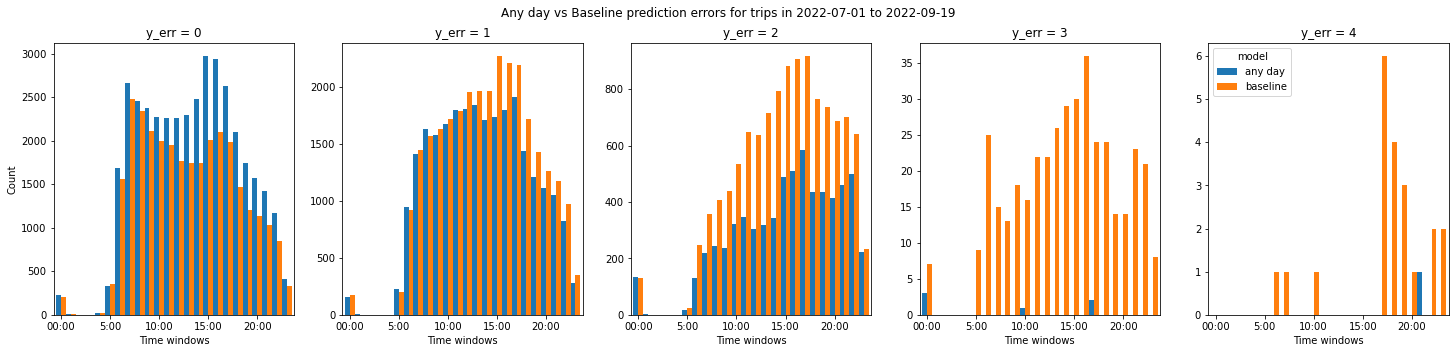

In [173]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(ncols=5, figsize=(25, 5), sharey=False)

loc = ticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals

for i in range(5):
    res_df.reset_index().groupby(['time_window', 'model']).agg('first')[i].unstack().plot.bar(ax=ax[i], stacked=False, width=1.0, rot=0)
    if i < 4:
        ax[i].legend().remove()
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Time windows')
    ax[i].set_title(f'y_err = {i}')
    ax[i].set_xticklabels(['', '00:00', '5:00', '10:00', '15:00', '20:00'])

ax[0].set_ylabel('Count')
fig.suptitle('Any day vs Baseline prediction errors for trips in 2022-07-01 to 2022-09-19')

fp = 'any_day_vs_baseline_IBI.png'
plt.savefig(fp, dpi=200, bbox_inches='tight')

### Actual prediction process (for deployment)
> Can move to separate notebook
0. Mirror streamlit variables
1. Select date to predict
2. Get past data from range that share day of week values
3. Get average of certain values
4. Adjust data for new prediction date
5. Setup, predict and output results

In [ ]:
model012    = joblib.load('models/any_day/XGB_012.joblib')
model234    = joblib.load('models/any_day/XGB_234.joblib')
columns     = joblib.load('models/any_day/TL_X_columns.joblib')
ix_map      = joblib.load('models/any_day/TL_IX_map.joblib')
ohe_encoder = joblib.load('models/any_day/TL_OHE_encoders.joblib')

In [ ]:
import datetime as dt
from src import any_day_prediction_utils as prediction
date_to_predict = dt.date(2022, 4, 1)

In [ ]:
importlib.reload(prediction)

In [ ]:
past_df = prediction.get_past_data(spark, date_to_predict)
input_df = prediction.setup_input_data(date_to_predict, past_df)
display(input_df)
input_df = prediction.prepare_any_day_for_prediction(input_df, columns, ix_map, ohe_encoder)

In [ ]:
len(columns)

In [ ]:
input_df = input_df.reset_index(drop=True)
input_df = input_df[columns]

## Predict first stage 0-1-2
predictions = model012.predict(input_df)

unique, counts = np.unique(predictions, return_counts=True)
print(unique, counts)

input_df['y_pred'] = predictions
## Isolate predictions with bin 2 for 2-3-4
high_bin_df = input_df[input_df['y_pred'] == 2]
display(high_bin_df)
high_bin_df = high_bin_df.drop(['y_pred'], axis=1)
high_bin_index = high_bin_df.index
high_bin_df = high_bin_df[columns]

predictions = model234.predict(high_bin_df)

unique, counts = np.unique(predictions, return_counts=True)
print(unique, counts)

predictions = predictions + 2
input_df.loc[high_bin_index, 'y_pred'] = predictions
ohe_features = ['route_id_direction', 'is_holiday', 'dayofweek', 'is_school_break']
input_df[ohe_features] = ohe_encoder.inverse_transform(input_df.filter(regex='route_id_direction_|is_holiday_|dayofweek_|is_school_'))

results = prediction.generate_results(input_df, TIMEWINDOW=30)

In [ ]:
import seaborn as sns
sns.heatmap(results, annot=False)

In [ ]:
y_pred = model012.predict(input_df)

In [ ]:
unique, counts = np.unique(y_pred, return_counts=True)
unique, counts

In [ ]:
y_pred = model012.predict(X[(X['month_ix'] == 9) & (X['day_ix'] == 10)][columns])
unique, counts = np.unique(y_pred, return_counts=True)
unique, counts

In [ ]:
y_pred = model012.predict(X[columns])
unique, counts = np.unique(y_pred, return_counts=True)
unique, counts

# IGNORE

In [ ]:
import os
import joblib
os.chdir("/media/seconddrive/mta_stationing_problem")
fp = os.path.join('models/any_day/XGBOOST_RANDSEARCHCV_any_day.pkl')
best = joblib.load(fp)
best.best_params_